# Analysis of DrugBank Data
**Author:** Bartosz Czechowski (bc458939)  
**Contact:** b.czechowski@student.uw.edu.pl  
**Context:** Created as part of the Python Programming Course at MIMUW (2024/25 Winter Semester)

## Prerequisites

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
import os

FILE_NAME = os.path.join('data', 'drugbank_partial.xml')

# namespace
ns = {
    "db": "http://www.drugbank.ca", 
}

In [3]:
from utils.parser import Parser

parser = Parser(FILE_NAME)

## 1. Drug Information DataFrame

In [4]:
simple = {
    'name': 'db:name',
    'description': 'db:description',
    'state': 'db:state',
    'indication': 'db:indication',
    'mechanism-of-action': 'db:mechanism-of-action',
}
nested = {'food_interactions': 'db:food-interactions/db:food-interaction'}
drug_info_df = parser.extract(".", simple_fields=simple, nested_fields=nested)
drug_info_df

# type is a tag so its harder to extract
# we'll use pandas here directly as it may be the shortest way to do it
# we could also use the parser to extract the information
# but we would have to write a custom function to extract the information
df = pd.read_xml(FILE_NAME)
df = df[['name', 'type']]

drug_info_df = drug_info_df.merge(df, on='name', how='inner')
drug_info_df

,name,drugbank-id,description,state,indication,mechanism-of-action,food_interactions,type
0,Lepirudin,DB00001,Lepirudin is a recombinant hirudin formed by 6...,solid,Lepirudin is indicated for anticoagulation in ...,Lepirudin is a direct thrombin inhibitor used ...,[Avoid herbs and supplements with anticoagulan...,biotech
1,Cetuximab,DB00002,Cetuximab is a recombinant chimeric human/mous...,liquid,Cetuximab indicated for the treatment of local...,The epidermal growth factor receptor (EGFR) is...,[],biotech
2,Dornase alfa,DB00003,Dornase alfa is a biosynthetic form of human d...,liquid,Used as adjunct therapy in the treatment of cy...,Dornase alfa is a biosynthetic form of human D...,[],biotech
3,Denileukin diftitox,DB00004,A recombinant DNA-derived cytotoxic protein co...,liquid,For treatment of cutaneous T-cell lymphoma,Denileukin diftitox binds to the high-affinity...,[],biotech
4,Etanercept,DB00005,Dimeric fusion protein consisting of the extra...,liquid,Etanercept is indicated for the treatment of m...,There are two distinct receptors for TNF (TNFR...,[],biotech
...,...,...,...,...,...,...,...,...
95,Octreotide,DB00104,Acromegaly is a disorder caused by excess grow...,solid,Octreotide by injection is used for the treatm...,Octreotide binds to somatostatin receptors cou...,[Take on an empty stomach. The oral capsules s...,biotech
96,Interferon alfa-2b,DB00105,Interferon alpha 2b (human leukocyte clone hif...,liquid,"For the treatment of hairy cell leukemia, mali...",Interferon alpha binds to type I interferon re...,[Avoid alcohol.],biotech
97,Abarelix,DB00106,Synthetic decapeptide antagonist to gonadotrop...,solid,For palliative treatment of advanced prostate ...,Abarelix binds to the gonadotropin releasing h...,[],small molecule
98,Oxytocin,DB00107,Sir Henry H. Dale first identified oxytocin an...,liquid,Administration of exogenous oxytocin is indica...,Oxytocin plays a vital role in labour and deli...,[],biotech


## 2. Synonyms dataframe and graph

In [10]:
from utils.other import get_id_to_synonyms_df
id_to_synonyms_df = get_id_to_synonyms_df(parser)
id_to_synonyms_df

,id,name,synonyms
0,DB00001,Lepirudin,"[[Leu1, Thr2]-63-desulfohirudin, Desulfatohiru..."
1,BTD00024,Lepirudin,"[[Leu1, Thr2]-63-desulfohirudin, Desulfatohiru..."
2,BIOD00024,Lepirudin,"[[Leu1, Thr2]-63-desulfohirudin, Desulfatohiru..."
3,DB00002,Cetuximab,"[Cetuximab, Cétuximab, Cetuximabum]"
4,BTD00071,Cetuximab,"[Cetuximab, Cétuximab, Cetuximabum]"
...,...,...,...
332,BTD00016,Oxytocin,"[Oxitocina, Oxytocin]"
333,BIOD00016,Oxytocin,"[Oxitocina, Oxytocin]"
334,DB00108,Natalizumab,"[Anti-alpha4 integrin, Anti-VLA4, IMMUNOGLOBUL..."
335,BTD00083,Natalizumab,"[Anti-alpha4 integrin, Anti-VLA4, IMMUNOGLOBUL..."


In [6]:
def draw_synonyms(drug_id, fixed_seed = None):
    row = id_to_synonyms_df[id_to_synonyms_df["id"] == drug_id]
    if row.empty:
        print(f"Drug with id {drug_id} not found")
        return
    name = row["name"].iloc[0]
    synonyms = row["synonyms"].iloc[0]
    synonyms = [syn for syn in synonyms if syn != name]

    G = nx.Graph()
    nx.add_star(G, [name] + synonyms)

    node_colors = ['red' if node == name else 'blue' for node in G.nodes()]
    
    pos = nx.spring_layout(G, seed=fixed_seed)
    
    # Draw the graph without labels
    nx.draw(
        G,
        pos,
        with_labels=False,  # Turn off the default labels
        node_color=node_colors,
        node_size=1000,  # Node size
        edge_color="gray",
    )
    
    # Draw labels as nodes
    for node, (x, y) in pos.items():
        plt.scatter(x, y, s=1000, color='white', edgecolor='black', zorder=3)
        plt.text(
            x, y,
            node,
            fontsize=10,
            ha='center',
            va='center',
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.3')
        )
    
    plt.title("Synonyms Graph", fontsize=14)
    plt.axis('off')  # Hide axes
    plt.show()

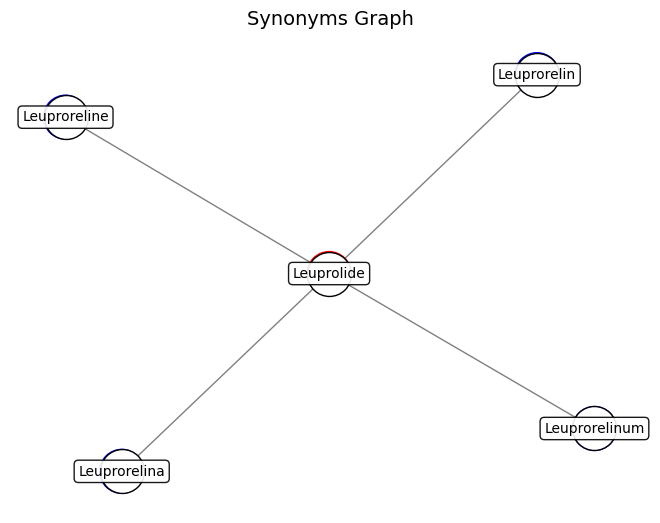

In [7]:
DRUG_ID = "DB00007"
draw_synonyms(DRUG_ID)

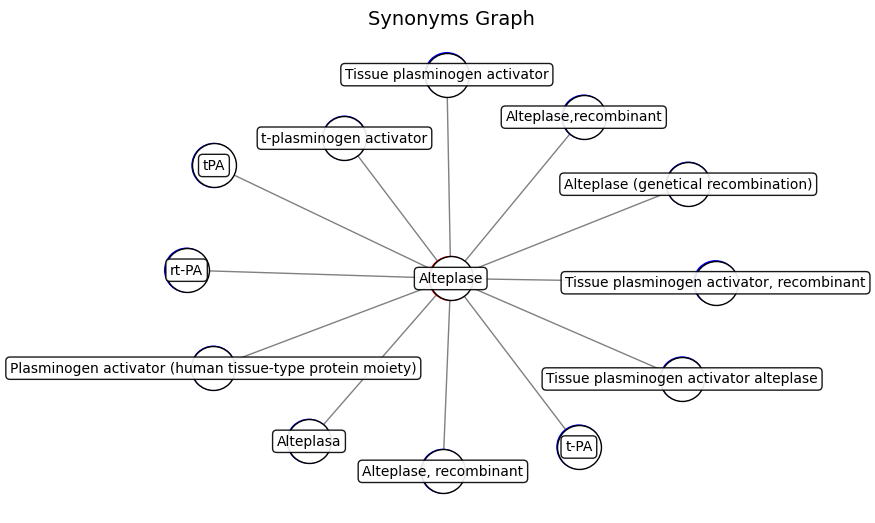

In [8]:
DRUG_ID = "DB00009"
# for large graphs some seeds can make long names overlap,
# so we fix (and possibly tweak) the seed to reduce the chance of that happening
draw_synonyms(DRUG_ID, 420) 

## 3. Pharmaceutical products

In [9]:
product_fields = {
    "product_name": "db:name",
    "labeller": "db:labeller",
    "ndc_product_code": "db:ndc-product-code",
    "dosage_form": "db:dosage-form",
    "route": "db:route",
    "strength": "db:strength",
    "country": "db:country",
    "source": "db:source",
}

product_df = parser.extract("db:products/db:product", product_fields)
product_df

,name,drugbank-id,product_name,labeller,ndc_product_code,dosage_form,route,strength,country,source
0,Lepirudin,DB00001,Refludan,Bayer,50419-150,Powder,Intravenous,50 mg/1mL,US,FDA NDC
1,Lepirudin,DB00001,Refludan,Bayer,None,"Powder, for solution",Intravenous,50 mg / vial,Canada,DPD
2,Lepirudin,DB00001,Refludan,Celgene Europe Limited,None,"Injection, solution, concentrate",Intravenous,50 mg,EU,EMA
3,Lepirudin,DB00001,Refludan,Celgene Europe Limited,None,"Injection, solution, concentrate",Intravenous,50 mg,EU,EMA
4,Lepirudin,DB00001,Refludan,Celgene Europe Limited,None,"Injection, solution, concentrate",Intravenous,20 mg,EU,EMA
...,...,...,...,...,...,...,...,...,...,...
4579,Natalizumab,DB00108,Tysabri,Elan Pharmaceuticals,59075-730,Injection,Intravenous,300 mg/15mL,US,FDA NDC
4580,Natalizumab,DB00108,Tysabri,Biogen Inc.,64406-008,Injection,Intravenous,300 mg/15mL,US,FDA NDC
4581,Natalizumab,DB00108,Tysabri,Biogen,None,Solution,Intravenous,300 mg / 15 mL,Canada,DPD
4582,Natalizumab,DB00108,Tysabri,Biogen Netherlands B.V.,None,"Injection, solution, concentrate",Intravenous,300 mg,EU,EMA


## 4. Number of pathways

In [11]:
# we'll reuse the function
simple = {"pathway-name": "db:name"}
nested = {"drugs": "db:drugs/db:drug/db:name"}
pathway_df = parser.extract(
    "db:pathways/db:pathway",
    simple_fields=simple,
    nested_fields=nested, 
    drug_id=None,
    drug_name=None
)
# answer to the question:
pathway_df["pathway-name"].nunique()

12

## 5. Pathway and drugs interacting with it graph

In [13]:
# the previous df already answers this question
pathway_df

,pathway-name,drugs
0,Lepirudin Action Pathway,"[Lepirudin, Phylloquinone, Calcium]"
1,Cetuximab Action Pathway,[Cetuximab]
2,Bivalirudin Action Pathway,"[Bivalirudin, Phylloquinone, Calcium]"
3,Alteplase Action Pathway,"[Alteplase, Phylloquinone, Calcium]"
4,Urokinase Action Pathway,"[Urokinase, Phylloquinone, Calcium]"
5,Reteplase Action Pathway,"[Reteplase, Phylloquinone, Calcium]"
6,Anistreplase Action Pathway,"[Anistreplase, Phylloquinone, Calcium]"
7,Tenecteplase Action Pathway,"[Tenecteplase, Phylloquinone, Calcium]"
8,Abciximab Action Pathway,[Abciximab]
9,Eptifibatide Action Pathway,[Eptifibatide]


In [15]:
# but the exploded version is more useful
pathway_exploded_df = pathway_df.explode('drugs')
pathway_exploded_df.head()

,pathway-name,drugs
0,Lepirudin Action Pathway,Lepirudin
0,Lepirudin Action Pathway,Phylloquinone
0,Lepirudin Action Pathway,Calcium
1,Cetuximab Action Pathway,Cetuximab
2,Bivalirudin Action Pathway,Bivalirudin


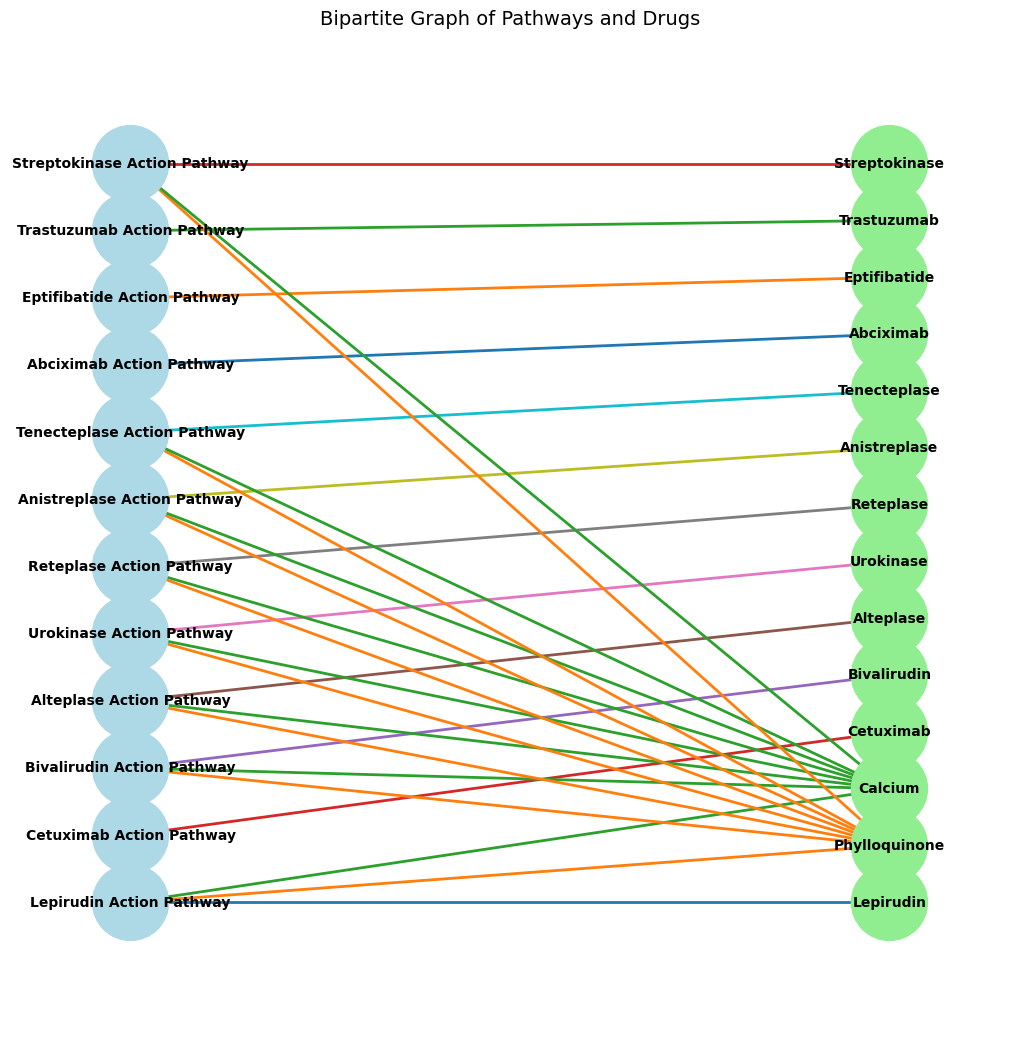

In [16]:
import networkx as nx
from textwrap import shorten

G = nx.Graph()

# nodes
pathways = pathway_exploded_df["pathway-name"].unique()
drugs = pathway_exploded_df["drugs"].unique()
G.add_nodes_from(pathways, bipartite=0)
G.add_nodes_from(drugs, bipartite=1)

# edges
edges = list(pathway_exploded_df.itertuples(index=False, name=None))
G.add_edges_from(edges)

# Generate a color map for the pathways, alternatively could be a
drug_no = len(drugs)
drug_colors = {drug: f"C{i % drug_no}" for i, drug in enumerate(drugs)}
edge_colors = [drug_colors[edge[1]] for edge in G.edges()]

# drawing
plt.figure(figsize=(10, 10))
pos = nx.bipartite_layout(G, pathways)
# if a really long name were to be cut off, it would be replaced with "..."
node_labels = {node: shorten(node, width=15, placeholder="...") for node in G.nodes()}
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=3000,
    node_color=["lightblue" if n in pathways else "lightgreen" for n in G.nodes()],
    font_size=10,
    font_weight="bold",
    edge_color=edge_colors,
    width=2,
)

# to prevent cutting off the labels
x_limits = plt.xlim()
y_limits = plt.ylim()
plt.xlim(x_limits[0] - 0.1, x_limits[1] + 0.1)
plt.ylim(y_limits[0] - 0.1, y_limits[1] + 0.1)

plt.title("Bipartite Graph of Pathways and Drugs", fontsize=14)
plt.show()


## 6. Number of pathways interacted with for each drug

In [19]:
# if we're only interesting in the drugs described in the reduced dataset
drug_path_counts = pathway_exploded_df["drugs"].value_counts()
id_name_df = parser.extract_id_name_df()
drug_path_df = id_name_df[['name']].copy()
drug_path_df['pathway_count'] = drug_path_df['name'].map(lambda x: drug_path_counts.get(x, 0))
drug_path_df = drug_path_df.sort_values('pathway_count', ascending=False)
drug_path_df

,name,pathway_count
40,Urokinase,1
41,Urokinase,1
45,Reteplase,1
46,Reteplase,1
47,Reteplase,1
...,...,...
132,Aldesleukin,0
131,Aldesleukin,0
130,Aldesleukin,0
129,Glucagon,0


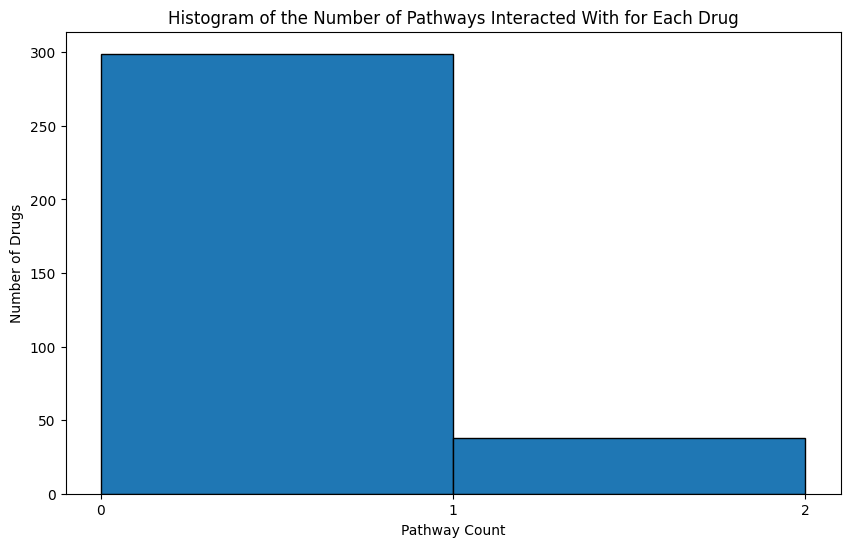

In [20]:
def plot_path_histogram(pth_df, col_name='pathway_count'):
    plt.figure(figsize=(10, 6))

    max_count = pth_df[col_name].max()
    hist_bins = range(0, max_count + 2)

    # Plot histogram with custom bins
    pth_df[col_name].hist(bins=hist_bins, edgecolor='black')

    # Set the x-ticks to match the bin edges
    plt.xticks(hist_bins)

    # Update the x-label
    plt.xlabel('Pathway Count')

    plt.ylabel('Number of Drugs')
    plt.title('Histogram of the Number of Pathways Interacted With for Each Drug')
    plt.grid(False)
    plt.show()

plot_path_histogram(drug_path_df)

In [21]:
# let's add the drugs not in our DB
drug_path_expanded_df = drug_path_df.copy()
new_drugs = drug_path_counts[~drug_path_counts.index.isin(id_name_df['name'])]
if not new_drugs.empty:
    print("Drugs not in the reduced dataset:")
    print(new_drugs.index)
    new_rows = pd.DataFrame({
        "name": new_drugs.index,
        "pathway_count": new_drugs.values
    })
    drug_path_expanded_df = pd.concat([drug_path_expanded_df, new_rows], ignore_index=True)

drug_path_expanded_df.sort_values('pathway_count', ascending=False)

Drugs not in the reduced dataset:
Index(['Phylloquinone', 'Calcium'], dtype='object', name='drugs')


,name,pathway_count
337,Phylloquinone,8
338,Calcium,8
28,Bivalirudin,1
29,Eptifibatide,1
30,Lepirudin,1
...,...,...
134,Denileukin diftitox,0
133,Etanercept,0
132,Etanercept,0
131,Etanercept,0


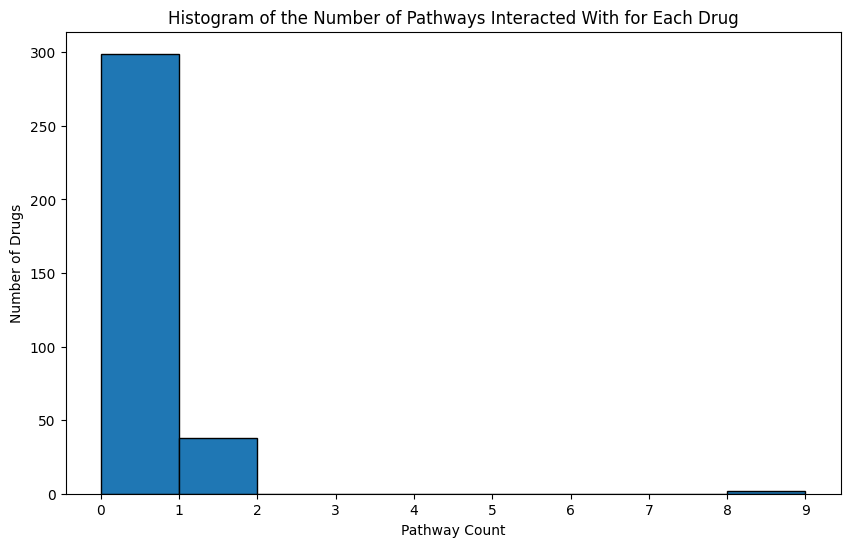

In [22]:
# let's reuse the previous function
plot_path_histogram(drug_path_expanded_df)

## 7. Protein interactions (targets)

In [23]:
# what we're looking for is too specific so it needs its own function
proteins_df = parser.extract_proteins()
proteins_df

,drug-name,target-id,source,polypeptide-id,polypeptide-name,gene-name,genatlas-id,locus,chromosome,location
0,Lepirudin,BE0000048,Swiss-Prot,P00734,Prothrombin,F2,F2,11p11-q12,11,Secreted
1,Cetuximab,BE0000767,Swiss-Prot,P00533,Epidermal growth factor receptor,EGFR,EGFR,7p12,7,Cell membrane
2,Cetuximab,BE0000901,Swiss-Prot,O75015,Low affinity immunoglobulin gamma Fc region re...,FCGR3B,FCGR3B,1q23,1,Cell membrane
3,Cetuximab,BE0002094,Swiss-Prot,P02745,Complement C1q subcomponent subunit A,C1QA,C1QA,1p36.12,1,Secreted
4,Cetuximab,BE0002095,Swiss-Prot,P02746,Complement C1q subcomponent subunit B,C1QB,C1QB,1p36.12,1,Secreted
...,...,...,...,...,...,...,...,...,...,...
244,Oxytocin,BE0000844,Swiss-Prot,P30559,Oxytocin receptor,OXTR,OXTR,3p25,3,Cell membrane
245,Natalizumab,BE0000590,Swiss-Prot,P13612,Integrin alpha-4,ITGA4,ITGA4,2q31.3,2,Membrane
246,Natalizumab,BE0000901,Swiss-Prot,O75015,Low affinity immunoglobulin gamma Fc region re...,FCGR3B,FCGR3B,1q23,1,Cell membrane
247,Natalizumab,BE0000710,Swiss-Prot,P12314,High affinity immunoglobulin gamma Fc receptor I,FCGR1A,FCGR1A,1q21.2-q21.3,1,Cell membrane


## 8. Pie chart of target cellular locations

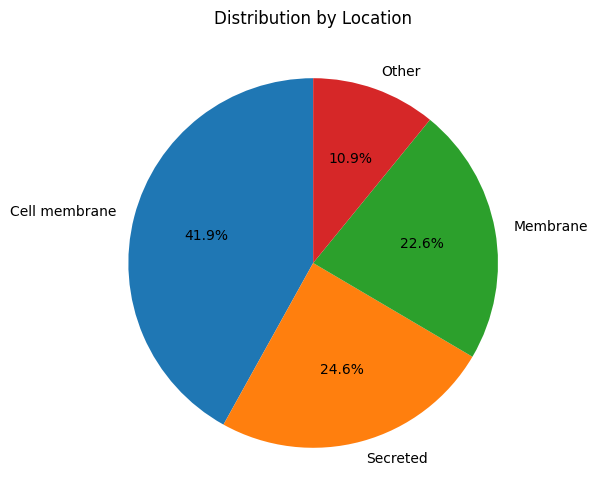

In [24]:
# we'll use the previous dataframe
location_counts = proteins_df['location'].value_counts()

def filter_small_categories(series, threshold=0.1, other_field='Other'):
    total = series.sum()
    filtered = series[series / total >= threshold]
    other_count = series[series / total < threshold].sum()
    filtered[other_field] = other_count
    return filtered

filtered_counts = filter_small_categories(location_counts)

plt.figure(figsize=(6, 6))
filtered_counts.plot.pie(
    autopct='%1.1f%%',  # Display percentages
    startangle=90,      # Rotate to start at the top
    colors=plt.cm.tab10.colors  # Use a predefined color map
)

# Add chart title and remove y-axis label
plt.title('Distribution by Location')
plt.ylabel('')  # Removes the default y-label
plt.show()

## 9. Drug groups dataframe and pie chart

In [25]:
# the function written earlier proves useful!
nested = {"groups": "db:groups/db:group"}
drug_groups_df = parser.extract(".", nested_fields=nested, drug_id=None)
drug_groups_exploded_df = drug_groups_df.explode('groups')
drug_groups_exploded_df

,name,groups
0,Lepirudin,approved
0,Lepirudin,withdrawn
1,Cetuximab,approved
2,Dornase alfa,approved
3,Denileukin diftitox,approved
...,...,...
97,Abarelix,withdrawn
98,Oxytocin,approved
98,Oxytocin,vet_approved
99,Natalizumab,approved


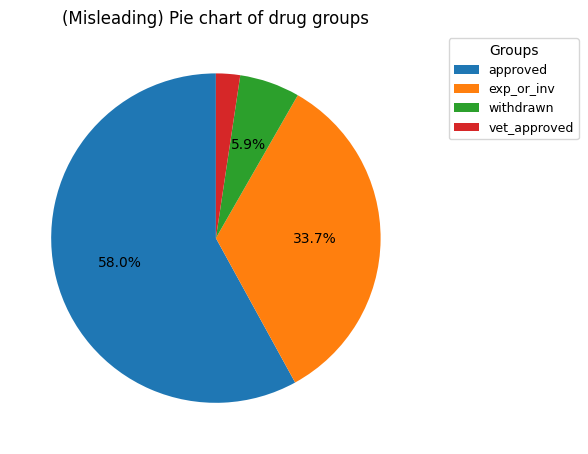

In [26]:
# We'll treat experimental and investigational as the same group (as per the task)
exploded_counts = drug_groups_exploded_df['groups'].value_counts()
exploded_counts_adj = exploded_counts.copy()
exploded_counts_adj["exp_or_inv"] = exploded_counts_adj["experimental"] + exploded_counts_adj["investigational"]
exploded_counts_adj.drop(["experimental", "investigational"], inplace=True)
exploded_counts_adj = exploded_counts_adj.sort_values(ascending=False)


total = exploded_counts.sum()

threshold = 5 # set a threshold for displaying percentages

# Use Matplotlib's `plt.pie()` directly
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    exploded_counts_adj,
    autopct=lambda p: f'{p:.1f}%' if p >= threshold else '',  # Label slices above the threshold
    startangle=90,         # Rotate to start at the top
    colors=plt.cm.tab10.colors,  # Use a predefined color map
    textprops={'fontsize': 10},  # Set font size for labels
)

# Add a legend for all groups
plt.legend(
    wedges,
    exploded_counts_adj.index,
    title="Groups",
    bbox_to_anchor=(1.05, 1),  # Position legend outside the chart
    loc='upper left',
    fontsize=9,
)
plt.title("(Misleading) Pie chart of drug groups")
plt.tight_layout()  # Adjust layout to make space for the legend
plt.show()


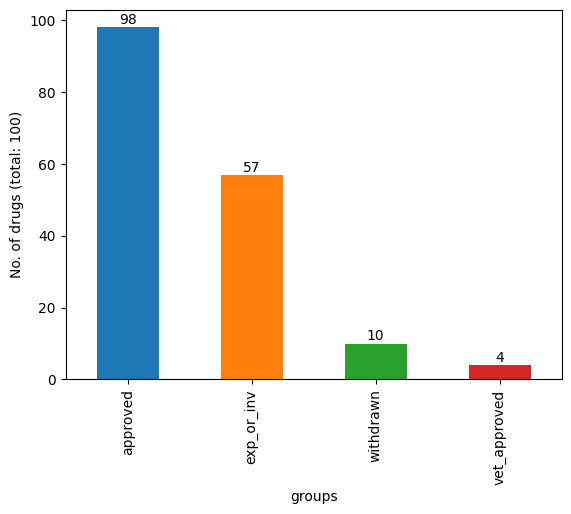

In [23]:
# I find the above misleading since the groups have major overlaps, so a pie chart is not the best choice
# therefore I'll use a bar chart instead
ax = exploded_counts_adj.plot(
    kind='bar',
    color=plt.cm.tab10.colors,
    ylabel=f'No. of drugs (total: {drug_groups_df.shape[0]})',
)

# Add the exact numbers on top of the bars
for p in ax.patches:
    height = p.get_height()  # Get the height of each bar
    ax.text(
        p.get_x() + p.get_width() / 2,  # X position of the text (center of the bar)
        height + 0.1,  # Y position of the text (a bit above the bar)
        f'{height:.0f}',  # Format the height as a number
        ha='center',  # Horizontal alignment of the text
        va='bottom',  # Vertical alignment of the text
        fontsize=10,  # Font size
    )

# Show the plot
plt.show()

In [24]:
# and the number of approved drugs that are not withdrawn
approved_drugs = drug_groups_df[drug_groups_df['groups'].apply(lambda x: 'approved' in x)]
approved_and_not_withdrawn = approved_drugs[~approved_drugs['groups'].apply(lambda x: 'withdrawn' in x)]
approved_and_not_withdrawn.shape[0]

89

## 10. Target interaction dataframe

In [27]:
simple = { 
    'target-id': 'db:id',
    'target-name': 'db:name'
}
nested = {
    'actions': 'db:actions/db:action'
}
prefix = "db:targets/db:target"
interaction_df = parser.extract(prefix, simple_fields=simple, nested_fields=nested, drug_id=None)
interaction_df

,name,target-id,target-name,actions
0,Lepirudin,BE0000048,Prothrombin,[inhibitor]
1,Cetuximab,BE0000767,Epidermal growth factor receptor,[binder]
2,Cetuximab,BE0000901,Low affinity immunoglobulin gamma Fc region re...,[binder]
3,Cetuximab,BE0002094,Complement C1q subcomponent subunit A,[binder]
4,Cetuximab,BE0002095,Complement C1q subcomponent subunit B,[binder]
...,...,...,...,...
262,Oxytocin,BE0000844,Oxytocin receptor,[agonist]
263,Natalizumab,BE0000590,Integrin alpha-4,[antibody]
264,Natalizumab,BE0000901,Low affinity immunoglobulin gamma Fc region re...,[ligand]
265,Natalizumab,BE0000710,High affinity immunoglobulin gamma Fc receptor I,[ligand]


## 11. Gene presentation

### a) Preparing the data

In [28]:
# we'll reuse dataframes from 3 for products and 7 for genes
# and merge them to get a relevant dataframe
product_gene_df = pd.merge(product_df, proteins_df, left_on='name', right_on='drug-name', how='inner')
product_gene_df.head()

,name,drugbank-id,product_name,labeller,ndc_product_code,dosage_form,route,strength,country,source_x,drug-name,target-id,source_y,polypeptide-id,polypeptide-name,gene-name,genatlas-id,locus,chromosome,location
0,Lepirudin,DB00001,Refludan,Bayer,50419-150,Powder,Intravenous,50 mg/1mL,US,FDA NDC,Lepirudin,BE0000048,Swiss-Prot,P00734,Prothrombin,F2,F2,11p11-q12,11,Secreted
1,Lepirudin,DB00001,Refludan,Bayer,None,"Powder, for solution",Intravenous,50 mg / vial,Canada,DPD,Lepirudin,BE0000048,Swiss-Prot,P00734,Prothrombin,F2,F2,11p11-q12,11,Secreted
2,Lepirudin,DB00001,Refludan,Celgene Europe Limited,None,"Injection, solution, concentrate",Intravenous,50 mg,EU,EMA,Lepirudin,BE0000048,Swiss-Prot,P00734,Prothrombin,F2,F2,11p11-q12,11,Secreted
3,Lepirudin,DB00001,Refludan,Celgene Europe Limited,None,"Injection, solution, concentrate",Intravenous,50 mg,EU,EMA,Lepirudin,BE0000048,Swiss-Prot,P00734,Prothrombin,F2,F2,11p11-q12,11,Secreted
4,Lepirudin,DB00001,Refludan,Celgene Europe Limited,None,"Injection, solution, concentrate",Intravenous,20 mg,EU,EMA,Lepirudin,BE0000048,Swiss-Prot,P00734,Prothrombin,F2,F2,11p11-q12,11,Secreted


In [30]:
# we'll filter out only the interesting columns
product_gene_df = product_gene_df[['drug-name', 'product_name', 'gene-name']]
product_gene_df.drop_duplicates(inplace=True)
product_gene_df

,drug-name,product_name,gene-name
0,Lepirudin,Refludan,F2
6,Cetuximab,Erbitux,EGFR
7,Cetuximab,Erbitux,FCGR3B
8,Cetuximab,Erbitux,C1QA
9,Cetuximab,Erbitux,C1QB
...,...,...,...
13559,Oxytocin,Truemed Group LLC,OXTR
13560,Natalizumab,Tysabri,ITGA4
13561,Natalizumab,Tysabri,FCGR3B
13562,Natalizumab,Tysabri,FCGR1A


### b) most common genes

In [31]:
# lets find the most common genes
# by active ingredients
drug_gene_counts = product_gene_df[['gene-name', 'drug-name']].drop_duplicates().groupby('gene-name').count()
drug_gene_counts = drug_gene_counts.sort_values('drug-name', ascending=False)
# and by the pharmaceutical products
product_gene_counts = product_gene_df[['gene-name', 'product_name']].drop_duplicates().groupby('gene-name').count()
product_gene_counts = product_gene_counts.sort_values('product_name', ascending=False)

top20_drug_genes = drug_gene_counts.head(20)
top20_product_genes = product_gene_counts.head(20)

# and by the intersection of the two
top20_intersect = set(top20_drug_genes.index) & set(top20_product_genes.index)
top20_intersect

{'FCGR1A',
 'FCGR2A',
 'FCGR2B',
 'FCGR2C',
 'FCGR3A',
 'FCGR3B',
 'IFNAR1',
 'IFNAR2',
 'IGF1R',
 'INSR'}

### c) avg number of products per drug hypothesis

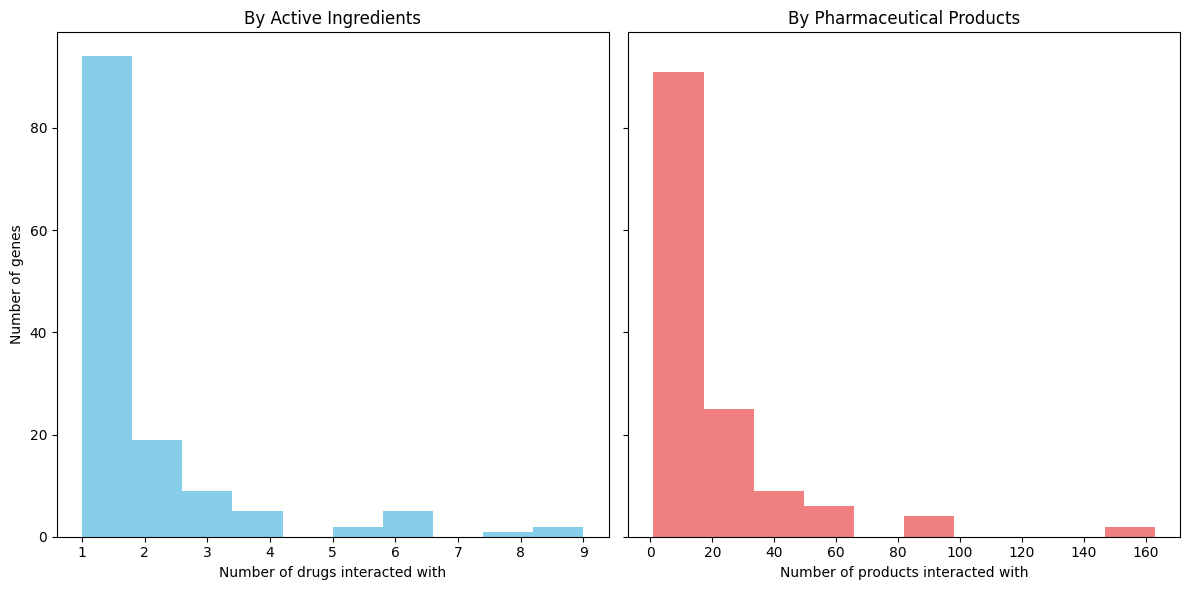

In [29]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot the first series (drug_gene_counts) on the first subplot
drug_gene_counts.plot(
    kind='hist',
    ax=axes[0],
    legend=None,
    color='skyblue',
    title='By Active Ingredients',
    xlabel='Number of drugs interacted with',
    ylabel='Number of genes'
)

# Plot the second series (product_gene_counts) on the second subplot
product_gene_counts.plot(
    kind='hist',
    ax=axes[1],
    legend=None,
    color='lightcoral',
    title='By Pharmaceutical Products',
    xlabel='Number of products interacted with',
    ylabel=''  # No ylabel for the second plot since sharey=True
)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

We can see that the general shape is the same, and the x-axis appears to just be scaled by a factor of "avg products per active ingredient" $\approx 18$. Lets verify how much off our guess is

In [32]:
drug_product_df = product_gene_df[['drug-name', 'product_name']].drop_duplicates()
avg_prod_per_drug = drug_product_df.groupby('drug-name').count().mean()
avg_prod_per_drug

product_name    8.518519
dtype: float64

Well our estimate was pretty far off, likely for two (main) reasons:
- the factor of 18 seems to work for the general shape at first sight, but actually isn't that good 
- the dataset (and the laws of statistics) don't work like that so it was just a wild guess

### d) drawing a graph of products interacting with given gene

In [33]:
def draw_products_interacting_with_gene(gene):
    products_interacting = product_gene_df[product_gene_df['gene-name'] == gene]['product_name']
    if products_interacting.empty:
        print(f"No products interact with gene {gene}")
        return
    G = nx.Graph()
    nx.add_star(G, [gene] + products_interacting.tolist())

    pos = nx.spring_layout(G)
    node_colors = ['red' if node == gene else 'cyan' for node in G.nodes()]

    plt.figure(figsize=(10, 8))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,
        node_size=1000,
        font_size=10,
        font_weight='bold',
        edge_color='gray'
    )
    plt.title(f"Products Interacting with Gene: {gene}", fontsize=14)
    plt.show()


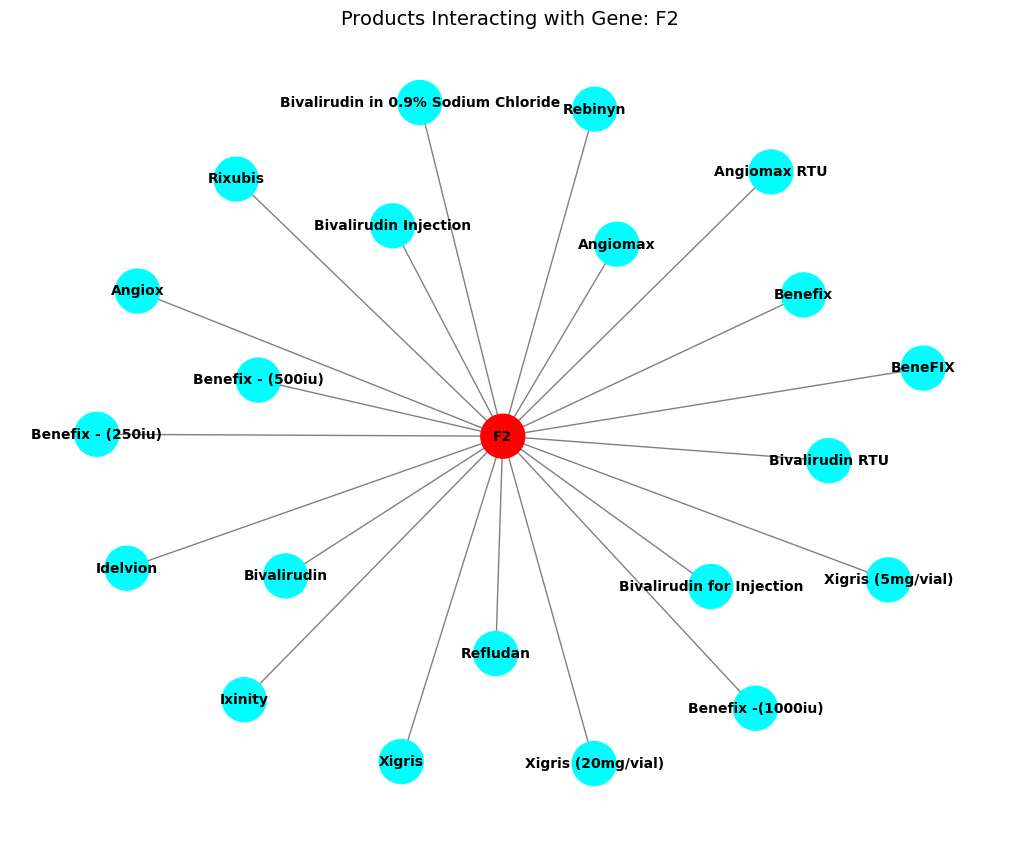

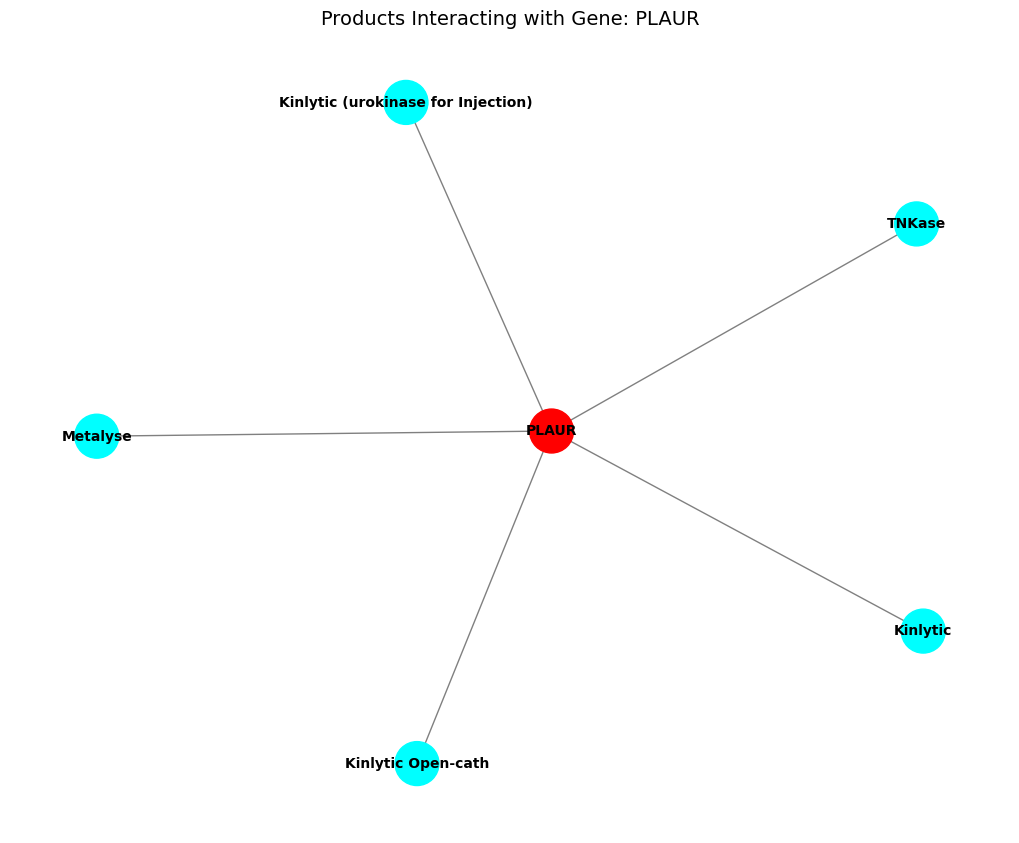

In [35]:
draw_products_interacting_with_gene("F2")
draw_products_interacting_with_gene("PLAUR")
# not too interesting since the graph is too large
# draw_products_interacting_with_gene("INSR")

## 12. Personal Presentation

We'll fetch some data from the UniProt API.

In [36]:
proteins_df = parser.extract_proteins()
polypeptide_names = proteins_df[proteins_df['polypeptide-name'].apply(lambda x: ' ' not in x)]['polypeptide-name'].drop_duplicates().reset_index(drop=True)
polypeptide_names

0               Prothrombin
1         Lymphotoxin-alpha
2               Plasminogen
3                 Nidogen-1
4                Syndecan-2
5              Calreticulin
6                  Calnexin
7               Tetranectin
8           Synaptotagmin-2
9               Vitronectin
10           Thrombomodulin
11    Alpha-2-macroglobulin
Name: polypeptide-name, dtype: object

In [37]:
import utils.uniprot_query as uq
years, families = uq.fetch_uniprot(polypeptide_names) # can take a while, since it fetches the uniport API

Draw a histogram of when were entries on proteins which are interacted with, by the drugs in our DB added to UniProt.

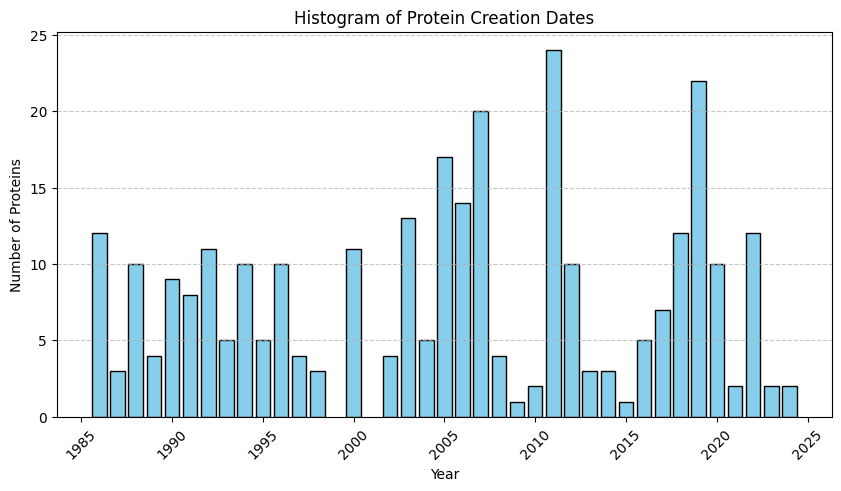

In [38]:
from collections import Counter
year_counts = Counter(years)

# Convert to DataFrame for sorting
df = pd.DataFrame(year_counts.items(), columns=["Year", "Count"]).sort_values("Year")

# Plot histogram
plt.figure(figsize=(10, 5))
plt.bar(df["Year"], df["Count"], color='skyblue', edgecolor='black')
plt.xlabel("Year")
plt.ylabel("Number of Proteins")
plt.title("Histogram of Protein Creation Dates")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

And find all the families that the proteins belong to.

In [39]:
families

{'Belongs to the LDLR family',
 'Belongs to the SERBP1-HABP4 family',
 'Belongs to the SNF2/RAD54 helicase family. RAD16 subfamily',
 'Belongs to the TRAFAC class translation factor GTPase superfamily. Classic translation factor GTPase family. EF-G/EF-2 subfamily',
 'Belongs to the TRAFAC class translation factor GTPase superfamily. Classic translation factor GTPase family. EF-Tu/EF-1A subfamily',
 'Belongs to the alpha-2-MRAP family',
 'Belongs to the anion channel-forming bestrophin (TC 1.A.46) family. Calcium-sensitive chloride channel subfamily',
 'Belongs to the calreticulin family',
 'Belongs to the calycin superfamily. Lipocalin family',
 'Belongs to the enolase family',
 'Belongs to the extended synaptotagmin family',
 'Belongs to the integrin alpha chain family',
 'Belongs to the multicopper oxidase family',
 'Belongs to the neurexin family',
 'Belongs to the peptidase A26 family',
 'Belongs to the peptidase S1 family',
 'Belongs to the peptidase S1 family. Plasminogen subfami

## 13. Mock database generation 

Code generating the mock database can be found in [generate_mock_dp.py](./generate_mock_db.py), but by default it generates a smaller database than 20000 drugs as it would be about ~4 GB in size. The generated data isn't analysed as
- it's generated kind of poorly
- the analysis would have to be done differently than in this file since some assumptions were made that are not true for the generated data (e.g. uniqueness of names)

## 14. Tests 

Tests can be found in the [tests/](tests/) folder.

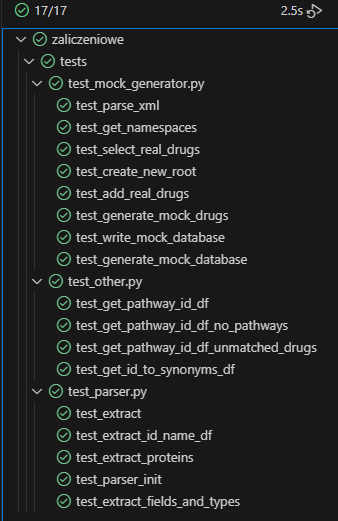

## 15. Uvicorn FASTAPI server for number of pathways of a given drug

The solution can be found in the [server.py](./server.py) file.
To test it the server should be started from the main directory by running: 
```bash
uvicorn server:app --reload
```
then the server will respond to requests which can be sent as such:
```bash
curl -X POST "http://127.0.0.1:8000/pathways/" -H "Content-Type: application/json" -d '{"id": "DRUG_ID"}'
```
below is a demonstration (echo added as curl doesn't add a newline after the result)

![server console logging screenshot](img/server.png)

![Client queries screenshot](img/client.png)